In [1]:
import os
import zipfile
import io
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "movielens_data"
ZIP_URL = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"

os.makedirs(DATA_DIR, exist_ok=True)
zip_path = f"{DATA_DIR}/ml-latest-small.zip"

if not os.path.exists(zip_path):
    print("Downloading MovieLens dataset...")
    r = requests.get(ZIP_URL)
    with open(zip_path, "wb") as f:
        f.write(r.content)
else:
    print("Already downloaded.")

#Extract
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(DATA_DIR)

print("Dataset ready!")


Dataset ready!


In [3]:
ratings = pd.read_csv("movielens_data/ml-latest-small/ratings.csv")
movies = pd.read_csv("movielens_data/ml-latest-small/movies.csv")


In [5]:
print("Ratings shape:", ratings.shape)
print("Movies shape:", movies.shape)

Ratings shape: (100836, 4)
Movies shape: (9742, 3)


In [7]:
print('Ratings:', ratings.head())
print('Movies:',movies.head())

Ratings:    userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
Movies:    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [8]:
popularity = ratings.groupby("movieId").agg(
    rating_count=("rating", "count"),
    avg_rating=("rating", "mean")
).reset_index()


In [9]:
popularity = popularity.merge(movies, on="movieId")
popularity.head()

,movieId,rating_count,avg_rating,title,genres
0,1,215,3.920930,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,110,3.431818,Jumanji (1995),Adventure|Children|Fantasy
2,3,52,3.259615,Grumpier Old Men (1995),Comedy|Romance
3,4,7,2.357143,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,49,3.071429,Father of the Bride Part II (1995),Comedy


In [10]:
top_popular = popularity.sort_values(
    by="rating_count", ascending=False
).head(10)

top_popular

,movieId,rating_count,avg_rating,title,genres
314,356,329,4.164134,Forrest Gump (1994),Comedy|Drama|Romance|War
277,318,317,4.429022,"Shawshank Redemption, The (1994)",Crime|Drama
257,296,307,4.197068,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
510,593,279,4.161290,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
1938,2571,278,4.192446,"Matrix, The (1999)",Action|Sci-Fi|Thriller
224,260,251,4.231076,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
418,480,238,3.750000,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
97,110,237,4.031646,Braveheart (1995),Action|Drama|War
507,589,224,3.970982,Terminator 2: Judgment Day (1991),Action|Sci-Fi
461,527,220,4.225000,Schindler's List (1993),Drama|War


In [11]:
top_rated = popularity[popularity["rating_count"] >= 50] \
    .sort_values(by="avg_rating", ascending=False) \
    .head(10)

top_rated

,movieId,rating_count,avg_rating,title,genres
277,318,317,4.429022,"Shawshank Redemption, The (1994)",Crime|Drama
659,858,192,4.289062,"Godfather, The (1972)",Crime|Drama
2224,2959,218,4.272936,Fight Club (1999),Action|Crime|Drama|Thriller
974,1276,57,4.271930,Cool Hand Luke (1967),Drama
602,750,97,4.268041,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
686,904,84,4.261905,Rear Window (1954),Mystery|Thriller
921,1221,129,4.259690,"Godfather: Part II, The (1974)",Crime|Drama
6298,48516,107,4.252336,"Departed, The (2006)",Crime|Drama|Thriller
913,1213,126,4.250000,Goodfellas (1990),Crime|Drama
694,912,100,4.240000,Casablanca (1942),Drama|Romance


In [12]:
m = popularity["rating_count"].quantile(0.80)
C = popularity["avg_rating"].mean()

def weighted(row):
    v = row["rating_count"]
    R = row["avg_rating"]
    return (v/(v+m))*R + (m/(v+m))*C

popularity["score"] = popularity.apply(weighted, axis=1)

top_weighted = popularity.sort_values(by="score", ascending=False).head(10)

top_weighted

,movieId,rating_count,avg_rating,title,genres,score
277,318,317,4.429022,"Shawshank Redemption, The (1994)",Crime|Drama,4.386472
659,858,192,4.289062,"Godfather, The (1972)",Crime|Drama,4.228673
2224,2959,218,4.272936,Fight Club (1999),Action|Crime|Drama|Thriller,4.220215
224,260,251,4.231076,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.186880
46,50,204,4.237745,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.183562
461,527,220,4.225000,Schindler's List (1993),Drama|War,4.175213
921,1221,129,4.259690,"Godfather: Part II, The (1974)",Crime|Drama,4.174818
6693,58559,149,4.238255,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.165524
897,1196,211,4.215640,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,4.164347
913,1213,126,4.250000,Goodfellas (1990),Crime|Drama,4.164126


In [13]:
#genres exploration
explode_genres = top_popular["genres"].str.split("|").explode()
genre_diversity_score = explode_genres.nunique()
genre_distribution = explode_genres.value_counts()

genre_diversity_score, genre_distribution


(10,
 genres
 Drama        5
 Action       5
 Sci-Fi       4
 Thriller     4
 Crime        3
 War          3
 Comedy       2
 Adventure    2
 Romance      1
 Horror       1
 Name: count, dtype: int64)

In [14]:
recommended = top_popular["movieId"].nunique()
total_movies = popularity["movieId"].nunique()

coverage = recommended / total_movies
coverage

0.0010283833813245578

In [17]:
#Genre-based non-personalized recommender
def top_movies_by_genre(pop_df, genre, n=10, min_count=20):
    mask = pop_df["genres"].str.contains(genre, na=False)
    genre_movies = pop_df[mask]
    genre_movies = genre_movies[genre_movies["rating_count"] >= min_count]
    return genre_movies.sort_values(by="rating_count", ascending=False).head(n)

#Top 10 Action movies
top_action = top_movies_by_genre(popularity, "Action", n=10)
top_action


,movieId,rating_count,avg_rating,title,genres,score
1938,2571,278,4.192446,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.153963
224,260,251,4.231076,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.186880
418,480,238,3.750000,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.726598
97,110,237,4.031646,Braveheart (1995),Action|Drama|War,3.994576
507,589,224,3.970982,Terminator 2: Judgment Day (1991),Action|Sci-Fi,3.934955
2224,2959,218,4.272936,Fight Club (1999),Action|Crime|Drama|Thriller,4.220215
897,1196,211,4.215640,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,4.164347
615,780,202,3.445545,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,3.435277
899,1198,200,4.207500,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,4.154007
910,1210,196,4.137755,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,4.087257


In [18]:
#Extract year
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)
popularity = popularity.merge(movies[['movieId','year']], on='movieId', how='left')


In [19]:
#Top after year 2010:
top_recent = popularity[popularity['year'] >= 2010].sort_values(
    by="rating_count", ascending=False
).head(10)

top_recent


,movieId,rating_count,avg_rating,title,genres,score,year
7355,79132,143,4.066434,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,4.004190,2010.0
7750,91529,76,3.993421,"Dark Knight Rises, The (2012)",Action|Adventure|Crime|IMAX,3.893743,2012.0
8358,109487,73,3.993151,Interstellar (2014),Sci-Fi|IMAX,3.889993,2014.0
8045,99114,71,3.943662,Django Unchained (2012),Action|Drama|Western,3.845173,2012.0
7675,89745,69,3.869565,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX,3.779622,2012.0
7241,74458,67,4.022388,Shutter Island (2010),Drama|Mystery|Thriller,3.906954,2010.0
8457,112852,59,4.050847,Guardians of the Galaxy (2014),Action|Adventure|Sci-Fi,3.917597,2014.0
7449,81845,58,4.043103,"King's Speech, The (2010)",Drama,3.909277,2010.0
7396,80463,57,3.885965,"Social Network, The (2010)",Drama,3.777527,2010.0
7338,78499,55,4.109091,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX,3.957453,2010.0


In [20]:
#Hybrid Non-Personalized score
popularity['hybrid_score'] = (
    0.6 * popularity['rating_count'] +
    0.4 * popularity['score']
)

top_hybrid = popularity.sort_values(by="hybrid_score", ascending=False).head(10)
top_hybrid


,movieId,rating_count,avg_rating,title,genres,score,year,hybrid_score
314,356,329,4.164134,Forrest Gump (1994),Comedy|Drama|Romance|War,4.132403,1994.0,199.052961
277,318,317,4.429022,"Shawshank Redemption, The (1994)",Crime|Drama,4.386472,1994.0,191.954589
257,296,307,4.197068,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.161910,1994.0,185.864764
510,593,279,4.161290,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.124225,1991.0,169.049690
1938,2571,278,4.192446,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.153963,1999.0,168.461585
224,260,251,4.231076,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.186880,1977.0,152.274752
418,480,238,3.750000,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.726598,1993.0,144.290639
97,110,237,4.031646,Braveheart (1995),Action|Drama|War,3.994576,1995.0,143.797830
507,589,224,3.970982,Terminator 2: Judgment Day (1991),Action|Sci-Fi,3.934955,1991.0,135.973982
461,527,220,4.225000,Schindler's List (1993),Drama|War,4.175213,1993.0,133.670085


#Visualizations

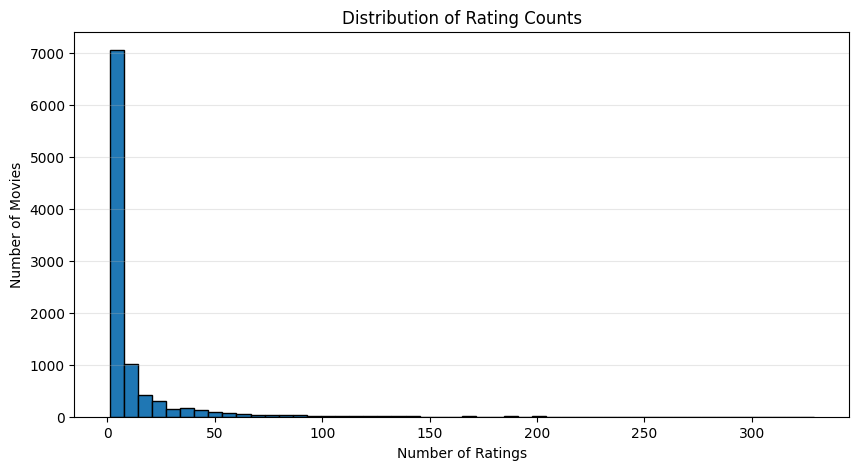

In [21]:
#Distribution of Rating Counts
plt.figure(figsize=(10,5))
plt.hist(popularity["rating_count"], bins=50, edgecolor='black')
plt.title("Distribution of Rating Counts")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.grid(axis='y', alpha=0.3)
plt.show()


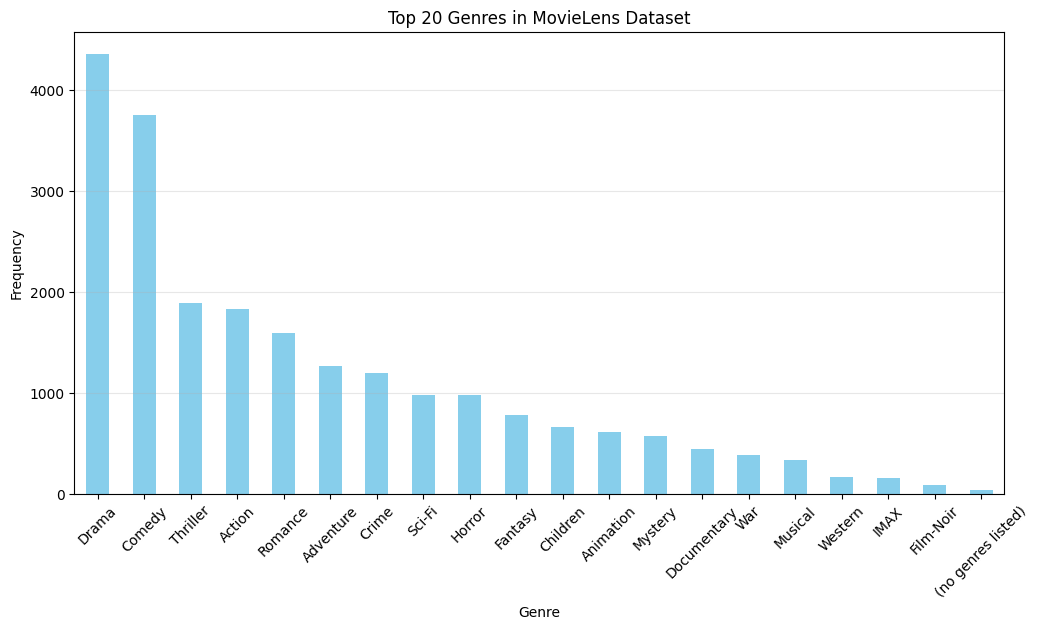

In [22]:
#Genre Distribution
genre_dist_full = movies["genres"].str.split("|").explode().value_counts().head(20)

plt.figure(figsize=(12,6))
genre_dist_full.plot(kind="bar", color="skyblue")
plt.title("Top 20 Genres in MovieLens Dataset")
plt.xlabel("Genre")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

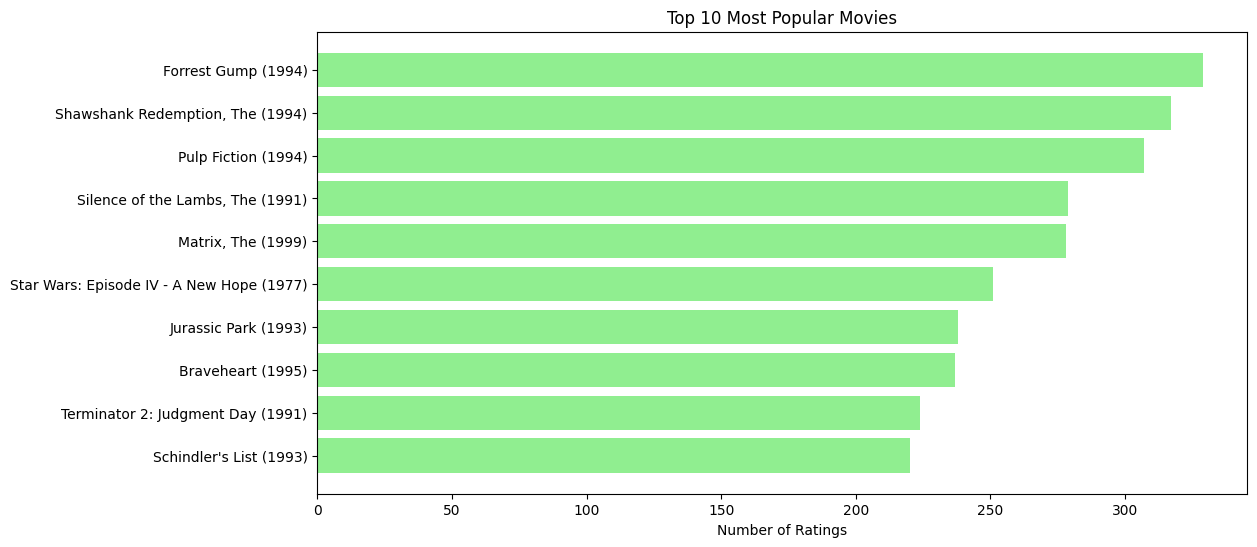

In [23]:
#Top 10 Popular Movies
plt.figure(figsize=(12,6))
plt.barh(top_popular['title'], top_popular['rating_count'], color='lightgreen')
plt.xlabel("Number of Ratings")
plt.title("Top 10 Most Popular Movies")
plt.gca().invert_yaxis()
plt.show()

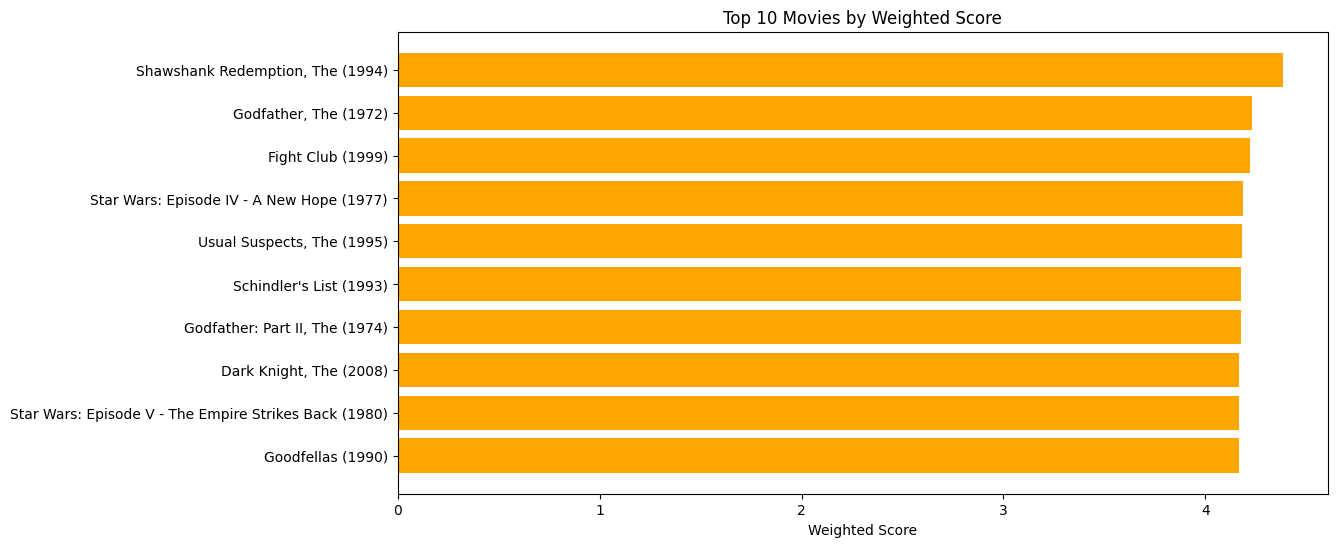

In [24]:
#Top 10 Weighted Movies
plt.figure(figsize=(12,6))
plt.barh(top_weighted['title'], top_weighted['score'], color='orange')
plt.xlabel("Weighted Score")
plt.title("Top 10 Movies by Weighted Score")
plt.gca().invert_yaxis()
plt.show()

In [27]:
os.makedirs("outputs", exist_ok=True)

top_popular.to_csv("outputs/top_popular.csv", index=False)
top_rated.to_csv("outputs/top_rated.csv", index=False)
top_weighted.to_csv("outputs/top_weighted.csv", index=False)

"Files saved in /content/outputs/"

'Files saved in /content/outputs/'